# Drought hazard team SPI output processing

In [16]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi_spei_smi')
import utils

#### BC SWITCH (toggle on / off)

In [42]:
BC_SWITCH = True

## GWL slicing

In [17]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


In [22]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/full_period/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/full_period/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

for input_file in files:
    print(f"---> GWL slicing for {input_file.rpartition('/')[-1]}")
    model_list = ['CMCC-ESM2','ACCESS-ESM1-5','ACCESS-CM2','EC-Earth3','CESM2','CNRM-ESM2-1','MPI-ESM1-2-HR', 'NorESM2-MM'] 
    target_model = [model for model in model_list if model in input_file][0]
    variant_id = utils.data_source['CMIP6'][target_model]['variant-id']
    for GWL in [1.2, 1.5, 2.0, 3.0]:
        print('= GWL'+str(GWL))
        GWL_timeslice = get_GWL_timeslice(xr.open_dataset(input_file),'CMIP6',target_model,variant_id,'ssp370',GWL)

        # write to netcdf in output_dir
        GWL_timeslice.attrs['description'] = f"Standardised Precipitation Index computed using method of McKee et al. 1993 for {target_model} GWL{str(GWL)} using a base period of 1965-2014. Further details in supporting technical documentation."
        GWL_timeslice.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        GWL_timeslice.attrs['comment'] = f"Using data on {input_dir}"
        GWL_timeslice.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
        GWL_timeslice.to_netcdf(f"{output_dir}{input_file.rpartition('/')[-1][:-3]}_GWL{str(GWL)}.nc")

---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_BOM_v1-r1_baseper

## Percent time below SPI < -1

In [31]:
SPI_threshold = -1
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

In [32]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_

In [28]:
print(f"Computing pct time below {str(SPI_threshold)}")
for spi_file in files:
    print(f"-> for {spi_file.rpartition('/')[-1]}")
    spi_xr = xr.open_dataset(spi_file)
    pct_below_thresh = 100*((spi_xr.SPI3)<=SPI_threshold).sum(dim='time')/len(spi_xr.SPI3.time)
    
    # write to netcdf in output_dir
    pct_below_thresh.attrs['description'] = f"Standardised Precipitation Index percent of months below {str(SPI_threshold)} for input file: {spi_file.rpartition('/')[-1]} in {input_dir}. "
    pct_below_thresh.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    pct_below_thresh.attrs['GWL'] = f"GWL {spi_file[-6:-3]}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    pct_below_thresh.to_netcdf(f"{output_dir}{(spi_file.rpartition('/')[-1][:-3])[:5]+'pct_time_below_-1'+(spi_file.rpartition('/')[-1][:-3])[4:]}.nc", mode='w')

Computing pct time below -1
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-

### 10-50-90 Percentiles for GWL and change between GWLs

In [69]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*pct_time_below*baseperiod19652014*{}".format(input_dir, '.nc'))))

In [70]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACC

In [79]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file] if BC_SWITCH == False else [file[88:-58] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file] if BC_SWITCH == False else [file[88:-58] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


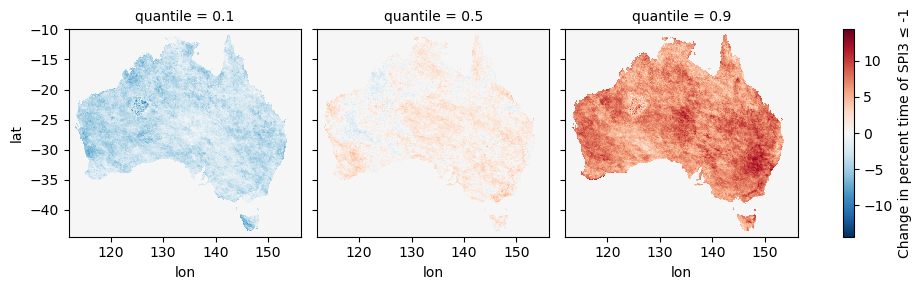

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

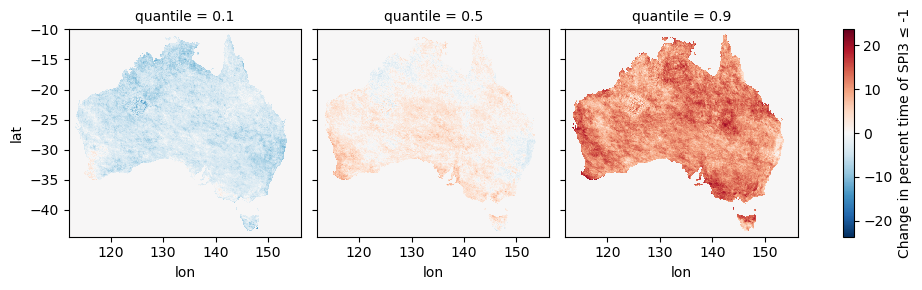

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

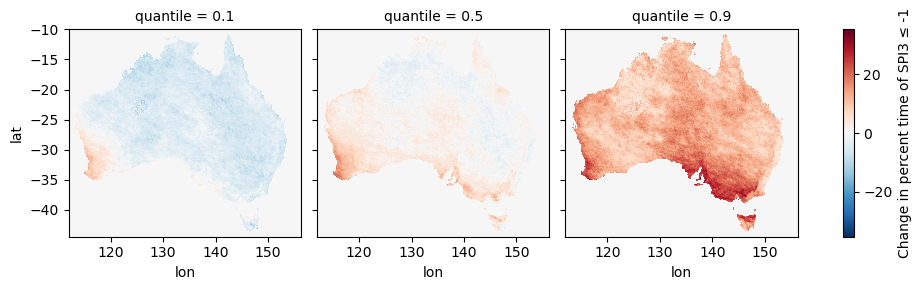

<Figure size 640x480 with 0 Axes>

In [80]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc")
    quick_check_ds.SPI3.plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in percent time of SPI3 ≤ -1'})
    plt.show()
    plt.clf()

## Plotting

In [81]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [82]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

CPU times: user 1min, sys: 469 ms, total: 1min
Wall time: 1min


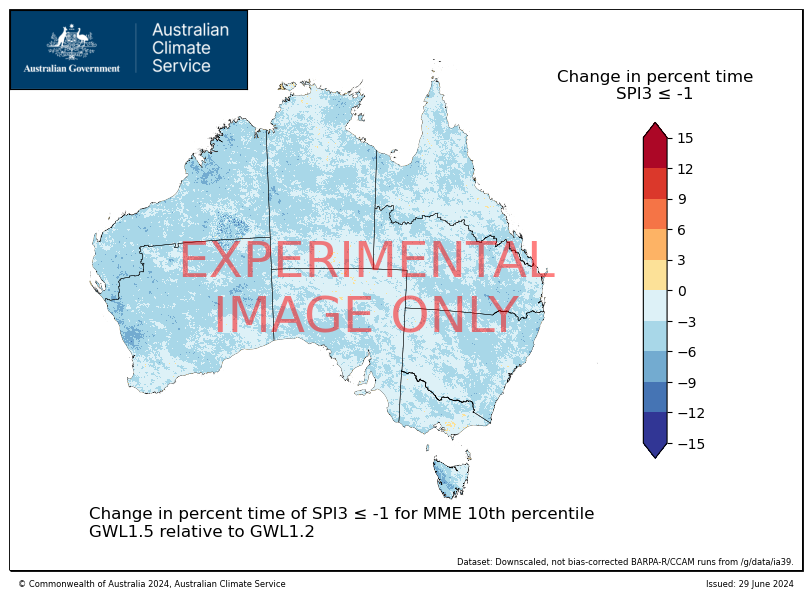

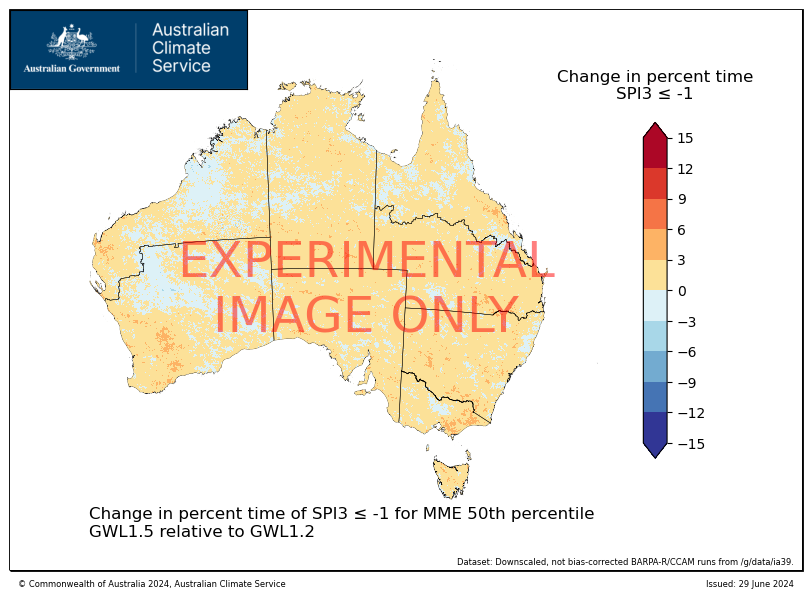

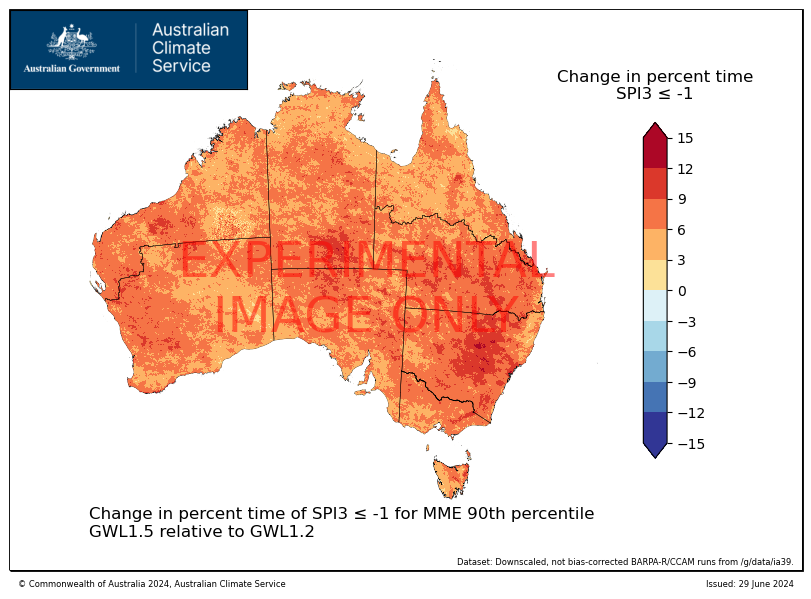

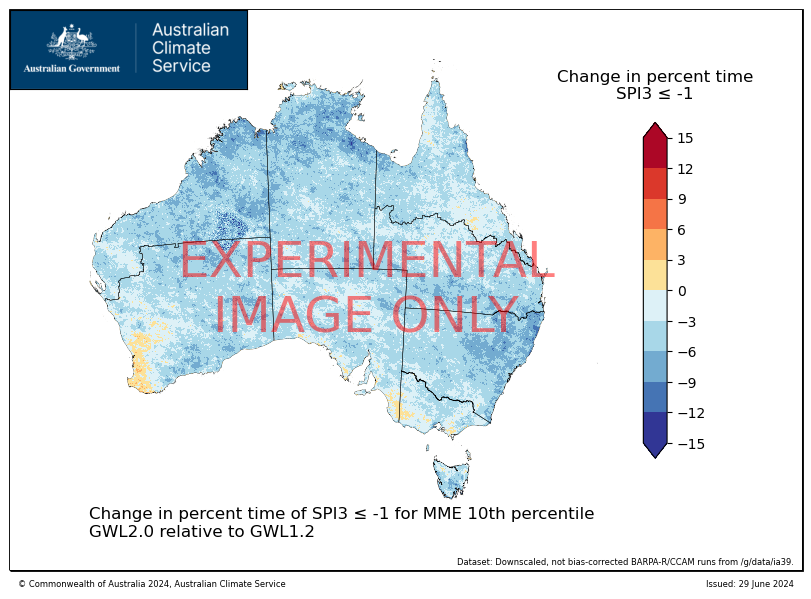

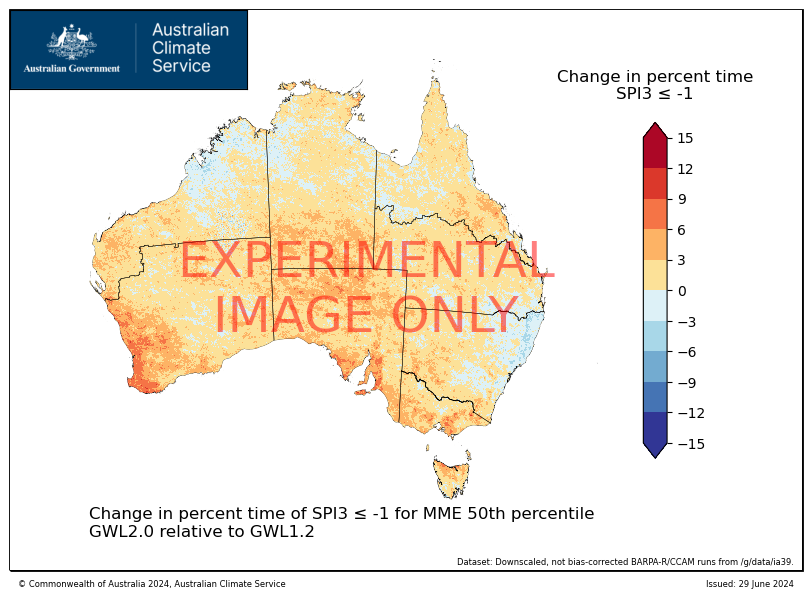

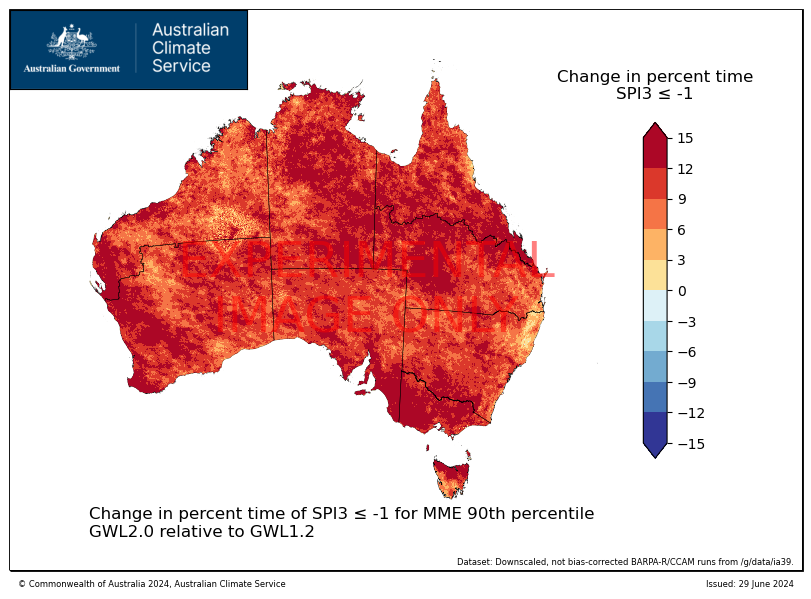

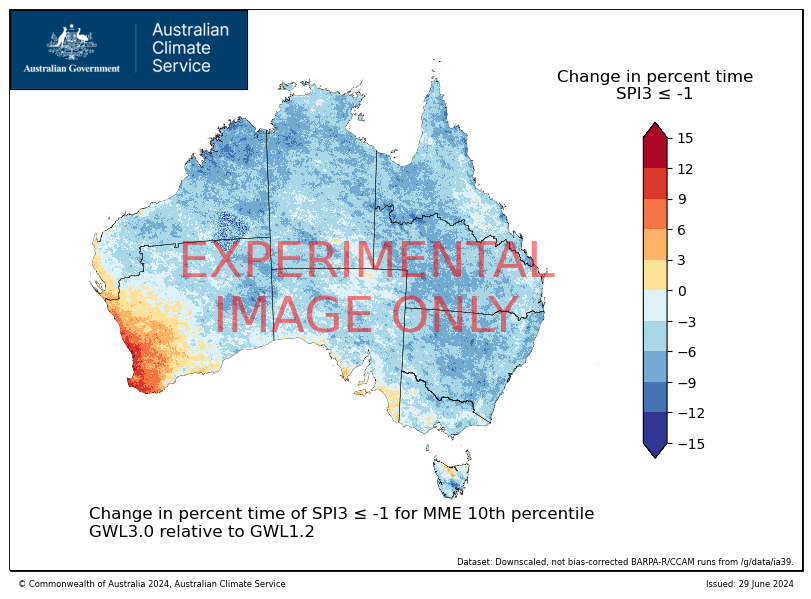

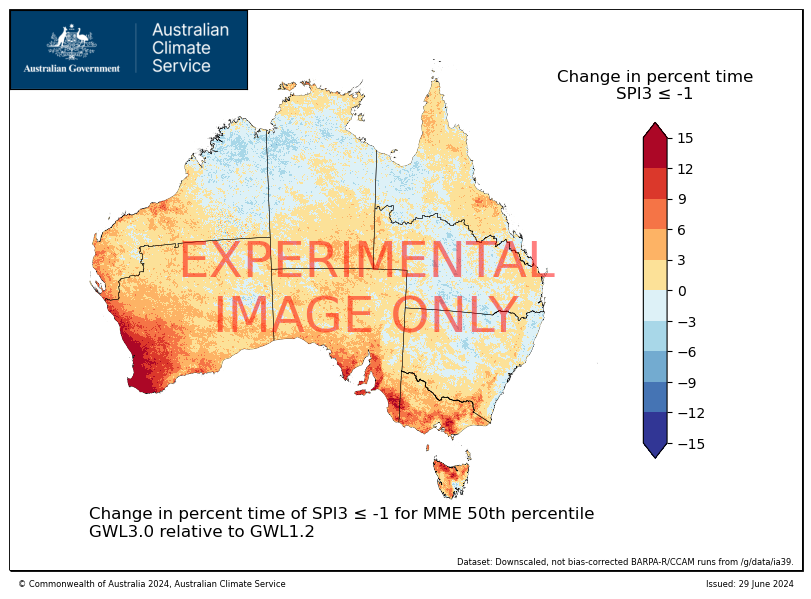

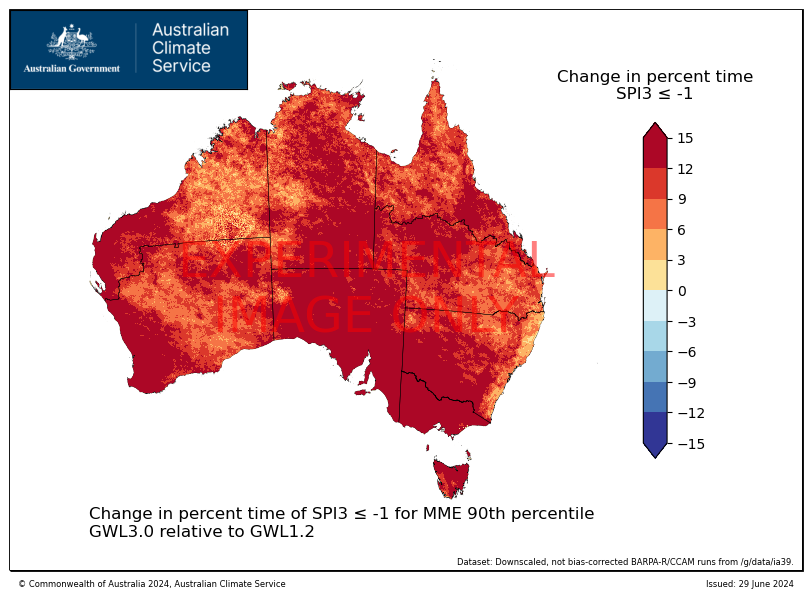

In [89]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        plot_file = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc'
        
        plot_acs_hazard(data = xr.open_dataset(plot_file).sel(quantile=percentile).SPI3,
                        regions = regions_dict['ncra_regions'],
                        cmap = cmap_dict["anom_b2r"],
                        ticks = np.arange(-15, 15.1, 3),
                        cbar_label = "Change in percent time\nSPI3 ≤ -1",
                        cbar_extend = "both",
                        title = f"Change in percent time of SPI3 ≤ -1 for MME {str(int(percentile*100))}th percentile",
                        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39.",
                        date_range = f"GWL{str(GWL)} relative to GWL1.2",
                        contourf = False,
                        contour = False
                       );

## Regional statistics

In [90]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [91]:
from acs_area_statistics import acs_regional_stats, regions

In [92]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*MME_change*{}".format(input_dir, '.nc'))))

In [93]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_MME_change_GWL1.5_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_MME_change_GWL2.0_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/SPI3_pct_time_below_-1_MME_change_GWL3.0_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc']

In [104]:
from IPython.display import display
for change_grid in files:
    for percentile in [0.1, 0.5, 0.9]:
        if BC_SWITCH:
            print_line = f'--> Calculating spatial summary statistics for {change_grid[-63:-47].replace("_", " ")} for {str(int(percentile*100))}th MME percentile.'
            save_line = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/MME_change_spatial_summary_statistics/{change_grid[-63:-47]}_change_for_MME_{str(int(percentile*100))}th_percentile_BC.csv'
        else:
            print_line = f'--> Calculating spatial summary statistics for {change_grid[-40:-24].replace("_", " ")} for {str(int(percentile*100))}th MME percentile.'
            save_line = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/MME_change_spatial_summary_statistics/{change_grid[-40:-24]}_change_for_MME_{str(int(percentile*100))}th_percentile.csv'
        print(print_line)
        print()
        ds = xr.open_dataset(change_grid).sel(quantile=percentile).rename({'SPI3': 'change_in_pct_time_SPI3_below_-1'})
        mask_frac = regions.mask_3D_frac_approx(ds)
        dims = ("lat", "lon",)
        regional_summary_ds = acs_regional_stats(ds=ds,var="change_in_pct_time_SPI3_below_-1", mask=mask_frac, dims = dims, how = ["min", "median", "max"])
        display(regional_summary_ds)
        regional_summary_ds.to_csv(save_line)

--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-13.000000,-4.083333,2.083333
1,WASouth,Western Australia South,-12.666667,-3.750000,0.496953
2,NSW,New South Wales and Australian Capital Territory,-8.166667,-3.166667,0.832492
3,VIC,Victoria,-7.000000,-2.583333,1.333333
4,SA,South Australia,-6.666667,-2.750000,0.817712
5,TAS,Tasmania,-9.676552,-3.666667,0.000000
6,NT,Northern Territory,-7.500000,-3.166667,1.666667
7,QLDNorth,Queensland North,-7.416667,-2.833333,0.916667
8,QLDSouth,Queensland South,-7.582385,-3.166667,0.083333


--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-5.000000,0.000000,5.000000
1,WASouth,Western Australia South,-3.750000,0.416667,5.000000
2,NSW,New South Wales and Australian Capital Territory,-2.500000,1.250000,5.000000
3,VIC,Victoria,-2.500000,0.833333,5.833333
4,SA,South Australia,-2.500000,1.250000,4.583333
5,TAS,Tasmania,-3.745595,1.250000,5.000000
6,NT,Northern Territory,-2.500000,0.833333,4.583333
7,QLDNorth,Queensland North,-2.500000,0.416667,5.416667
8,QLDSouth,Queensland South,-2.500000,0.833333,5.000000


--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-1.0,6.416667,11.914770
1,WASouth,Western Australia South,0.0,6.333333,14.333333
2,NSW,New South Wales and Australian Capital Territory,0.0,7.916667,13.416667
3,VIC,Victoria,0.0,6.666667,12.250000
4,SA,South Australia,0.0,6.500000,12.000000
5,TAS,Tasmania,0.0,5.500000,11.083333
6,NT,Northern Territory,0.0,6.416667,12.747771
7,QLDNorth,Queensland North,0.0,5.666667,11.750000
8,QLDSouth,Queensland South,0.0,7.416667,11.672586


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-17.583333,-5.083333,0.679314
1,WASouth,Western Australia South,-15.083333,-3.916667,5.875960
2,NSW,New South Wales and Australian Capital Territory,-11.916667,-4.750000,1.315806
3,VIC,Victoria,-8.414536,-2.750000,2.583333
4,SA,South Australia,-8.916667,-3.333333,3.318295
5,TAS,Tasmania,-13.000000,-3.750000,1.333333
6,NT,Northern Territory,-12.666667,-4.666667,0.581201
7,QLDNorth,Queensland North,-11.250000,-3.416667,1.416667
8,QLDSouth,Queensland South,-9.748633,-3.916667,0.833333


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-7.083333,0.833333,7.860230
1,WASouth,Western Australia South,-4.583333,2.083333,10.833333
2,NSW,New South Wales and Australian Capital Territory,-5.416667,0.416667,7.912268
3,VIC,Victoria,-2.083333,2.500000,10.000000
4,SA,South Australia,-3.333333,2.916667,9.583333
5,TAS,Tasmania,-6.250000,2.083333,8.750000
6,NT,Northern Territory,-4.583333,1.250000,7.484379
7,QLDNorth,Queensland North,-3.750000,0.833333,8.332644
8,QLDSouth,Queensland South,-4.256319,1.250000,5.833333


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-2.583333,9.416667,21.178674
1,WASouth,Western Australia South,0.000000,10.750000,23.666667
2,NSW,New South Wales and Australian Capital Territory,-0.583333,10.000000,20.231189
3,VIC,Victoria,0.000000,13.166667,20.166667
4,SA,South Australia,0.000000,10.416667,22.037415
5,TAS,Tasmania,0.000000,10.500000,19.666667
6,NT,Northern Territory,0.000000,11.583333,20.583333
7,QLDNorth,Queensland North,0.000000,11.500000,20.574884
8,QLDSouth,Queensland South,0.000000,11.416667,22.166667


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-16.666667,-5.500000,8.007725
1,WASouth,Western Australia South,-13.333333,-2.500000,16.277659
2,NSW,New South Wales and Australian Capital Territory,-11.000000,-5.750000,2.063052
3,VIC,Victoria,-9.250000,-3.583333,1.753364
4,SA,South Australia,-10.416667,-3.583333,5.892716
5,TAS,Tasmania,-12.833333,-3.250000,6.750000
6,NT,Northern Territory,-11.583333,-5.166667,2.076330
7,QLDNorth,Queensland North,-11.666667,-5.416667,1.333333
8,QLDSouth,Queensland South,-12.000000,-5.750000,0.000000


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-7.083178,0.000000,11.483486
1,WASouth,Western Australia South,-7.083333,2.916667,22.916667
2,NSW,New South Wales and Australian Capital Territory,-5.416667,0.000000,9.568602
3,VIC,Victoria,-2.500000,4.583333,15.000000
4,SA,South Australia,-3.333333,2.083333,15.394940
5,TAS,Tasmania,-6.666667,4.583333,14.583333
6,NT,Northern Territory,-6.666667,0.000000,7.083333
7,QLDNorth,Queensland North,-5.833333,0.416667,9.166667
8,QLDSouth,Queensland South,-5.416667,-0.416667,7.500000


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_pct_time_SPI3_below_-1_min,change_in_pct_time_SPI3_below_-1_median,change_in_pct_time_SPI3_below_-1_max
region,,,,,
0,WANorth,Western Australia North,-2.249987,9.583333,22.909327
1,WASouth,Western Australia South,-0.500000,10.833333,35.293239
2,NSW,New South Wales and Australian Capital Territory,-0.833333,12.083333,27.809867
3,VIC,Victoria,0.000000,22.916667,33.166667
4,SA,South Australia,0.000000,16.416667,32.233990
5,TAS,Tasmania,0.000000,17.000000,30.333333
6,NT,Northern Territory,0.000000,12.083333,20.579567
7,QLDNorth,Queensland North,0.000000,10.666667,19.749382
8,QLDSouth,Queensland South,0.000000,10.916667,20.666667
